# Clasificador de animales

En el siguiente notebook crearemos un clasificador de animales utilizando un dataset de Kaggle.

## Descarga del dataset

In [2]:
!cp "drive/MyDrive/kaggle.json" "/root/.kaggle/kaggle.json"
!kaggle datasets download -d alessiocorrado99/animals10 --unzip

100% 584M/586M [00:06<00:00, 97.3MB/s]
100% 586M/586M [00:06<00:00, 94.5MB/s]


## Librerías a utilizar

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0

## Variables globales

In [10]:
tf.random.set_seed(905)
BATCH_SIZE = 64
CLASS_MODE = 'categorical'
INPUT_SHAPE = (224, 224)
DROPOUT = 0.25
CHECK_PATH = '/content/drive/MyDrive/Clasificador de animales/'

## Data Augmentation

Debido a que poseemos un dataset pequeno, utilizaremos esta técnica para generar modificaciones en las imágenes existente y simular un dataset más grande.

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

In [11]:
train_ds = datagen.flow_from_directory(
    '/content/raw-img',
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True,
    subset='training'
)

test_ds = datagen.flow_from_directory(
    '/content/raw-img',
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True,
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


## Modelo

Utilizaremos un modelo convolucional con 4 niveles de convolución, aplicando BatchNormalization para mejorar el comportamiento del modelo y disminuir los tiempos de convergencia.
Utilizaremos Dropout y Regularizers para disminuir el Overfiting.

In [27]:
def create_model(input_shape=(224, 224), num_classes=10.):

  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  inputs = tf.keras.layers.Input(shape=input_shape+(3,))
  x = base_model(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [32]:
model = create_model(INPUT_SHAPE, train_ds.num_classes)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## Entrenamiento

Entrenaremos por 100 epocas, utilizando un Early Stop para detener el entrenamiento en caso de que no esté aprendiendo el modelo y reducir los tiempos de espera.

In [34]:
hist = model.fit(train_ds,
                 epochs=5,
                 validation_data=test_ds,
                 callbacks=[early_stop])

Epoch 1/5
328/328 [==============================] - 299s 899ms/step - loss: 0.6907 - accuracy: 0.8287 - val_loss: 0.1383 - val_accuracy: 0.9623
Epoch 2/5
328/328 [==============================] - 291s 887ms/step - loss: 0.1541 - accuracy: 0.9564 - val_loss: 0.1200 - val_accuracy: 0.9631
Epoch 3/5
328/328 [==============================] - 290s 885ms/step - loss: 0.1208 - accuracy: 0.9649 - val_loss: 0.1099 - val_accuracy: 0.9671
Epoch 4/5
328/328 [==============================] - 290s 883ms/step - loss: 0.1098 - accuracy: 0.9674 - val_loss: 0.1111 - val_accuracy: 0.9627
Epoch 5/5
328/328 [==============================] - 289s 882ms/step - loss: 0.1006 - accuracy: 0.9707 - val_loss: 0.1057 - val_accuracy: 0.9666


El modelo tuvo un val_loss de 0.3570 y un val_acc de 0.8858.

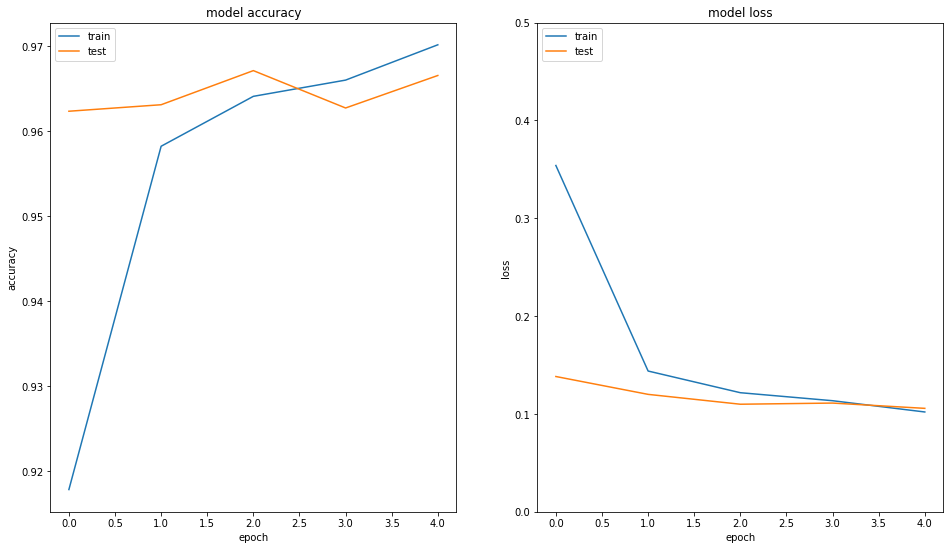

In [38]:
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylim(0, .5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Luego de finalizar el entrenamiento se realizó un fine tuning utilizando un lr de 1e-6 para mejorar el modelo.

In [36]:
model.evaluate(test_ds)

82/82 [==============================] - 55s 673ms/step - loss: 0.1059 - accuracy: 0.9648


[0.10586279630661011, 0.9648318290710449]

In [39]:
model.save(CHECK_PATH+'model_efficienttetb0.h5')

## Resultados

Observaremos algunas predicciones realizadas por el modelo.

In [48]:
from translate import translate

In [67]:
classes_value = train_ds.class_indices
value_classes = {v:k for k, v in classes_value.items()}

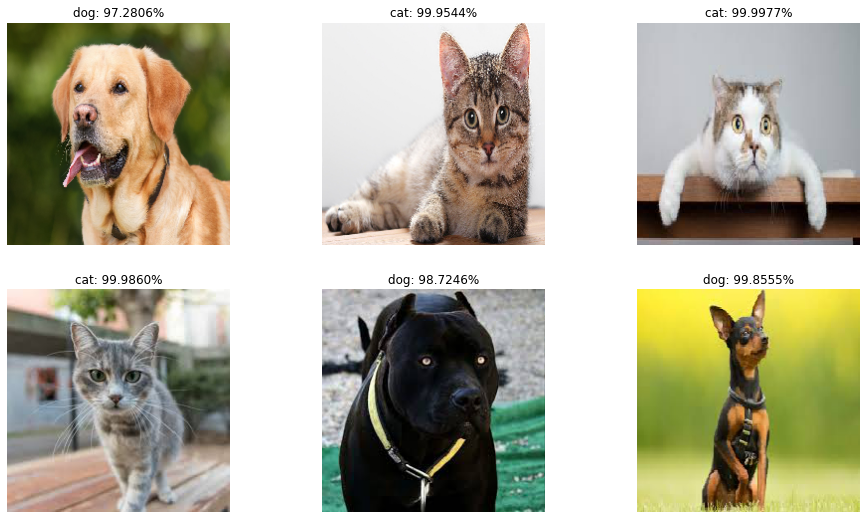

In [77]:
plt.figure(figsize=(16, 9))
for n in range(1, 7):
  img = f'/content/cat_or_dog_{n}.jpg'

  test_image = image.load_img(img, target_size = INPUT_SHAPE)
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image)
  prediction = value_classes[np.argmax(result)]
  traduction = translate[prediction]
  prob = max(result[0]) * 100

  plt.subplot(2, 3, n)
  plt.imshow(np.squeeze(test_image) / 255.)
  plt.title(f'{traduction}: {prob:2.4f}%')
  plt.axis('off')

plt.show()